![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 15 - Variational Auto-encoder </center>
### <center> Conditional VAE </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/15_VAE/MainCVAE.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchinfo

from torch.utils.data import DataLoader

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/15_VAE/DeepLearningFramework ./DeepLearningFramework

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath  = r'../../data/'
oTrainSet = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

In [6]:
batchSize = 128
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

mX, vY    = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

#### VAE encoder:

In [7]:
class Encoder(nn.Module):
    def __init__(self, D):
        super(Encoder, self).__init__()
        
        self.oEmbedding = nn.Embedding(10, 784)
        self.oEncoder   = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(2,  8,   kernel_size=5, bias=False),           nn.BatchNorm2d(8 ), nn.LeakyReLU(), 
            nn.Conv2d(8,  16,  kernel_size=5, bias=False),           nn.BatchNorm2d(16), nn.LeakyReLU(),
            nn.Conv2d(16, 32,  kernel_size=5, bias=False, stride=2), nn.BatchNorm2d(32), nn.LeakyReLU(),
            nn.Conv2d(32, 64,  kernel_size=5, bias=False),           nn.BatchNorm2d(64), nn.LeakyReLU(),
            nn.Conv2d(64, 2*D, kernel_size=4), 
            nn.Flatten()
        )
        
    def forward(self, mX, vY):
        mY        = self.oEmbedding(vY).view(-1, 1, 28, 28)
        mXY       = torch.cat      ([mX, mY], dim=1)
        mOut      = self.oEncoder  (mXY)
        mμ, mLogΣ = mOut.chunk     (2, dim=1)

        return mμ, mLogΣ
#=============================================================#
#=============================================================#
D = 2
print(torchinfo.summary(Encoder(D), (mX.shape, vY.shape), dtypes=[torch.float, torch.long]))

mμ,       mLogΣ = Encoder(D)(mX, vY)
mμ.shape, mLogΣ.shape

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Embedding: 1-1                         [128, 784]                7,840
├─Sequential: 1-2                        [128, 4]                  --
│    └─Identity: 2-1                     [128, 2, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 24, 24]          400
│    └─BatchNorm2d: 2-3                  [128, 8, 24, 24]          16
│    └─LeakyReLU: 2-4                    [128, 8, 24, 24]          --
│    └─Conv2d: 2-5                       [128, 16, 20, 20]         3,200
│    └─BatchNorm2d: 2-6                  [128, 16, 20, 20]         32
│    └─LeakyReLU: 2-7                    [128, 16, 20, 20]         --
│    └─Conv2d: 2-8                       [128, 32, 8, 8]           12,800
│    └─BatchNorm2d: 2-9                  [128, 32, 8, 8]           64
│    └─LeakyReLU: 2-10                   [128, 32, 8, 8]           --
│   

(torch.Size([128, 2]), torch.Size([128, 2]))

#### VAE decoder:

In [8]:
from DeepLearningFramework.Layers import Reshape

class Decoder(nn.Module):
    def __init__(self, D):
        super(Decoder, self).__init__()
        
        self.oEmbedding = nn.Embedding(10, 4)
        self.oDecoder   = nn.Sequential(
            nn.Identity(),
            Reshape((D+4, 1, 1)),
            nn.Upsample(scale_factor=2), nn.Conv2d(D+4, 64, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2), nn.Conv2d(64,  32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2), nn.Conv2d(32,  16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2), nn.Conv2d(16,  8,  kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(8 ), nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2), nn.Conv2d(8,   4,  kernel_size=3, padding=1, bias=True ),                     nn.LeakyReLU(), 
                                         nn.Conv2d(4,   1,  kernel_size=5, padding=0, bias=True ),
    )

    def forward(self, mZ, vY):
        mY    = self.oEmbedding(vY)
        mZY   = torch.cat      ([mZ, mY], dim=1)
        mHatX = self.oDecoder  (mZY)
        
        return mHatX
    

#=============================================================#
#=============================================================#
D = 2
torchinfo.summary(Decoder(D), (mμ.shape, vY.shape), dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  --                        --
├─Embedding: 1-1                         [128, 4]                  40
├─Sequential: 1-2                        [128, 1, 28, 28]          --
│    └─Identity: 2-1                     [128, 6]                  --
│    └─Reshape: 2-2                      [128, 6, 1, 1]            --
│    └─Upsample: 2-3                     [128, 6, 2, 2]            --
│    └─Conv2d: 2-4                       [128, 64, 2, 2]           3,456
│    └─BatchNorm2d: 2-5                  [128, 64, 2, 2]           128
│    └─LeakyReLU: 2-6                    [128, 64, 2, 2]           --
│    └─Upsample: 2-7                     [128, 64, 4, 4]           --
│    └─Conv2d: 2-8                       [128, 32, 4, 4]           18,432
│    └─BatchNorm2d: 2-9                  [128, 32, 4, 4]           64
│    └─LeakyReLU: 2-10                   [128, 32, 4, 4]           --
│    └─

### Conditional VAE (CVAE):

In [9]:
class CVAE(nn.Module):
    def __init__(self, D):
        super(CVAE, self).__init__()

        self.oEncoder = Encoder(D)
        self.oDecoder = Decoder(D)

    def forward(self, mX, vY):
        #-- Encode:
        mμ, mLogΣ = self.oEncoder(mX, vY)

        #-- Sample:
        if self.training == True:
            mϵ = torch.randn_like(mμ)
            vσ = torch.exp(.5 * mLogΣ)
            mZ = vσ * mϵ + mμ
        else:
            mZ = mμ

        #-- Decode:
        mHatX = self.oDecoder(mZ, vY)

        return mHatX, mμ, mLogΣ

#=============================================================#
#=============================================================#
D = 2
print(torchinfo.summary(CVAE(D), (mX.shape, vY.shape), dtypes=[torch.float, torch.long]))

mHatX,       mμ,       mLogΣ = CVAE(D)(mX, vY)
mHatX.shape, mμ.shape, mLogΣ.shape

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     --                        --
├─Encoder: 1-1                           [128, 2]                  --
│    └─Embedding: 2-1                    [128, 784]                7,840
│    └─Sequential: 2-2                   [128, 4]                  --
│    │    └─Identity: 3-1                [128, 2, 28, 28]          --
│    │    └─Conv2d: 3-2                  [128, 8, 24, 24]          400
│    │    └─BatchNorm2d: 3-3             [128, 8, 24, 24]          16
│    │    └─LeakyReLU: 3-4               [128, 8, 24, 24]          --
│    │    └─Conv2d: 3-5                  [128, 16, 20, 20]         3,200
│    │    └─BatchNorm2d: 3-6             [128, 16, 20, 20]         32
│    │    └─LeakyReLU: 3-7               [128, 16, 20, 20]         --
│    │    └─Conv2d: 3-8                  [128, 32, 8, 8]           12,800
│    │    └─BatchNorm2d: 3-9             [128, 32, 8, 8]           64
│   

(torch.Size([128, 1, 28, 28]), torch.Size([128, 2]), torch.Size([128, 2]))

### VAE loss:

$$L\left(\theta,\psi\right)=\frac{1}{N}\sum_{i=1}^{N}\left\Vert \boldsymbol{x}_{i}-\mathrm{D}_{\theta}\left(\boldsymbol{z}_{i}\right)\right\Vert _{2}^{2}+\beta D_{\mathrm{KL}}\left(\mathcal{N}\left(\boldsymbol{\mu}\left(\boldsymbol{x}_{i}\right),\boldsymbol{\Sigma}\left(\boldsymbol{x}_{i}\right)\right)||\mathcal{N}\left(\boldsymbol{0},\boldsymbol{I}\right)\right)$$
where:
$$D_{\mathrm{KL}}\left(\mathcal{N}_{d}\left(\boldsymbol{\mu},\text{diag}\left(\boldsymbol{\sigma}\right)\right)||\mathcal{N}_{d}\left(\boldsymbol{0},\boldsymbol{I}\right)\right)=\frac{1}{2}\sum_{i=1}^{d}\left(\sigma_{i}^{2}+\mu_{i}^{2}-1-\log\left(\sigma_{i}^{2}\right)\right)$$

In [10]:
class VAELoss():
    def __init__(self, β):
        self.β = β
    
    def __call__(self, mHatX, mμ, mLogVar, mX):
        MSE = nn.MSELoss(reduction='sum')(mHatX, mX)
        KLD = 0.5 * torch.sum(mμ**2 + mLogVar.exp() - 1 - mLogVar)
        N   = mX.shape[0]
    
        return (MSE + self.β * KLD) / N

#### Epoch:

In [11]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            mHatX, mμ, mLogΣ = oModel(mX, vY)
            loss             = Loss  (mHatX, mμ, mLogΣ, mX)
        else:
            with torch.no_grad():
                mHatX, mμ, mLogΣ = oModel(mX, vY)
                loss             = Loss  (mHatX, mμ, mLogΣ, mX)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = mX.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mHatX, mX)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [12]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import R2Score

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Metric = R2Score

β      = 1
Loss   = VAELoss(β)

### Train the model:

In [13]:
D          = 2
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)

oModel     = CVAE      (D).to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=5e-5, betas=(0.9, 0.99))
oScheduler = OneCycleLR(oOptim, max_lr=1e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='CVAE')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 61.964 | Val loss: 41.594 | Train Metric:  0.190 | Val Metric:  0.473 | epoch time:  5.553 | <-- Checkpoint!
Epoch 001: | Train loss: 39.409 | Val loss: 35.172 | Train Metric:  0.503 | Val Metric:  0.566 | epoch time:  5.412 | <-- Checkpoint!
Epoch 002: | Train loss: 35.259 | Val loss: 32.944 | Train Metric:  0.564 | Val Metric:  0.597 | epoch time:  5.594 | <-- Checkpoint!
Epoch 003: | Train loss: 33.710 | Val loss: 32.121 | Train Metric:  0.586 | Val Metric:  0.611 | epoch time:  5.341 | <-- Checkpoint!
Epoch 004: | Train loss: 32.936 | Val loss: 31.416 | Train Metric:  0.598 | Val Metric:  0.621 | epoch time:  5.209 | <-- Checkpoint!
Epoch 005: | Train loss: 32.327 | Val loss: 31.513 | Train Metric:  0.607 | Val Metric:  0.622 | epoch time:  5.339 | <-- Checkpoint!
Epoch 006: | Train loss: 31.918 | Val loss: 30.719 | Train Metric:  0.613 |

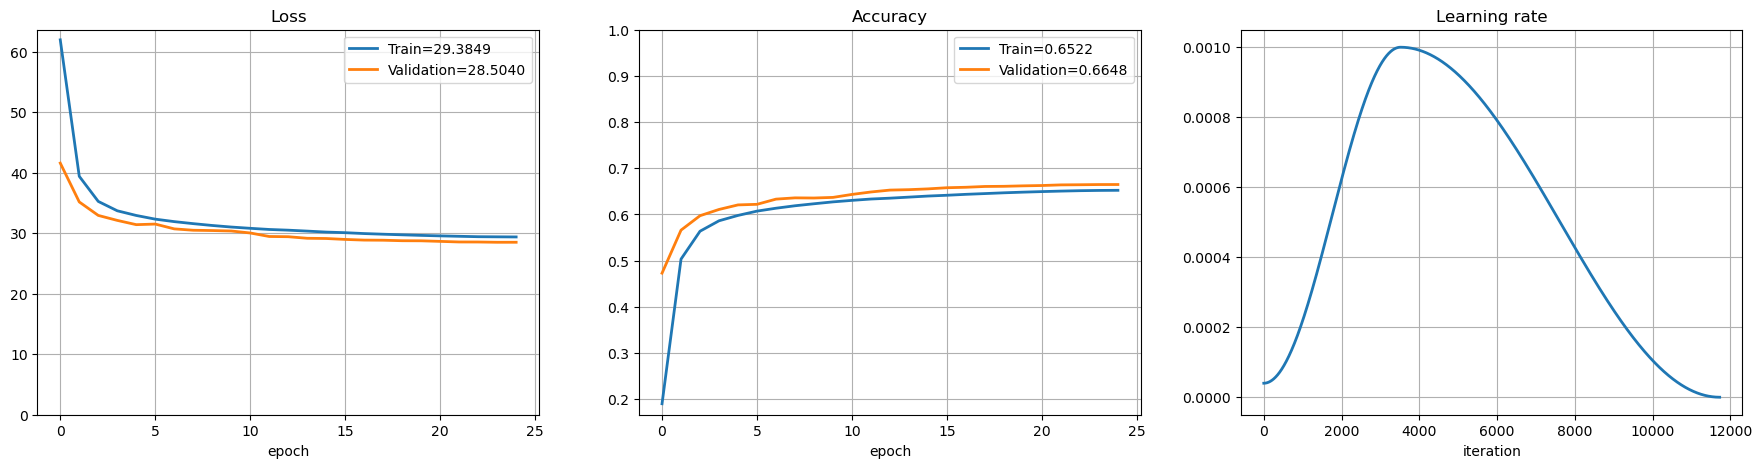

In [14]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [15]:
#-- Run this to load a trained model:
# oModel = CVAE(D).to(DEVICE)
# oModel.load_state_dict(torch.load('CVAE1.pt'))
# oModel.train(False);

#### Test reconstruction:

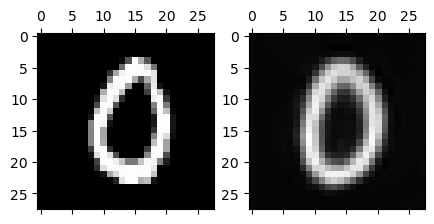

In [16]:
idx   = np.random.randint(len(oTestSet))
mX, y = oTestSet[idx]
mX    = mX.to(DEVICE)
y     = torch.tensor(y).to(DEVICE)
with torch.no_grad():
    mHatX = oModel(mX[None,...], y[None])[0][0]

_, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].matshow(mX   [0].cpu(), cmap='gray')
ax[1].matshow(mHatX[0].cpu(), cmap='gray')
plt.show()

### Generate data (using labels):

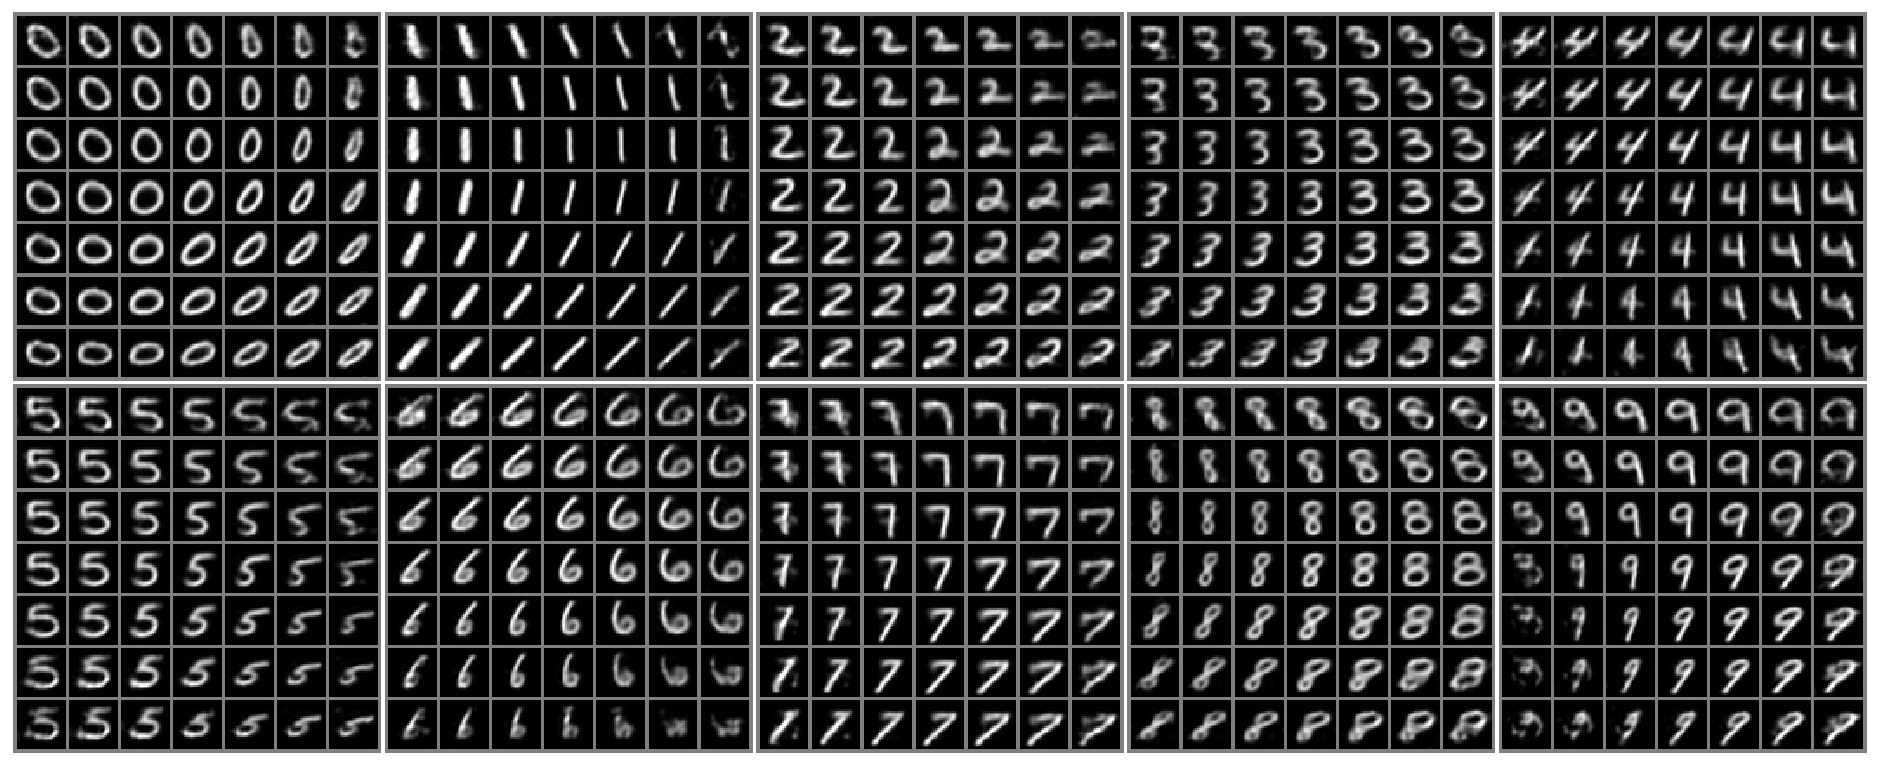

In [17]:
oDecoder   = oModel.oDecoder
v1         = torch.linspace(-3, 3, 7)
v2         = torch.linspace(-3, 3, 7)
mZZ1, mZZ2 = torch.meshgrid(v1, v2)
mZZ        = torch.stack   ([mZZ1.ravel(), mZZ2.ravel()], dim=1)

M          = mZZ.shape[0]
vOnes      = torch.ones(M, device=DEVICE, dtype=torch.long)

lG = []
with torch.no_grad():
    for yy in range(10):
        mNewX  = oDecoder(mZZ.to(DEVICE), yy*vOnes).cpu().squeeze(0)
        lG    += [torchvision.utils.make_grid(mNewX, nrow=7, pad_value=1/2)]
        
mG = torchvision.utils.make_grid(torch.stack(lG), nrow=5, pad_value=1)
mG = torch.clamp(mG.permute(1,2,0), 0, 1)

_, ax = plt.subplots(figsize=(24, 10))
ax.matshow(mG, cmap='gray')
ax.axis   ('off')
plt.show  ()